# F1 Model

In [285]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Final_F1 (1).csv")
df.head()

,Unnamed: 0,year,round,grid,positionOrder,points,laps,driver_nationality,name,constuctor_nationality,...,location,country,lat,lng,alt,date,target_finish,driver_age,driver_name,target_finish_e
0,0,2002,13,11,4,3.0,77.0,Finnish,Hungaroring,British,...,Budapest,Hungary,47.5789,19.24860,264,2002-08-18,Finished,23.0,Kimi Räikkönen,1
1,1,1981,1,23,21,0.0,16.0,British,Long Beach,British,...,California,USA,33.7651,-118.18900,12,1981-03-15,Not Finished,35.0,John Watson,0
2,2,1958,8,0,26,0.0,0.0,American,Nürburgring,Italian,...,Nürburg,Germany,50.3356,6.94750,578,1958-08-03,Not Finished,28.0,Troy Ruttman,0
3,3,2021,8,19,16,0.0,69.0,German,Red Bull Ring,American,...,Spielberg,Austria,47.2197,14.76470,678,2021-06-27,Not Finished,22.0,Mick Schumacher,0
4,4,1988,12,0,30,0.0,0.0,Italian,Autodromo Nazionale di Monza,Italian,...,Monza,Italy,45.6156,9.28111,162,1988-09-11,Not Finished,25.0,Stefano Modena,0


In [286]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [287]:
df.drop(['target_finish'], inplace=True, axis=1)

In [288]:
df.drop(['date'], inplace=True, axis=1)

In [289]:
df.head()

,year,round,grid,positionOrder,points,laps,driver_nationality,name,constuctor_nationality,constructor,location,country,lat,lng,alt,driver_age,driver_name,target_finish_e
0,2002,13,11,4,3.0,77.0,Finnish,Hungaroring,British,McLaren,Budapest,Hungary,47.5789,19.24860,264,23.0,Kimi Räikkönen,1
1,1981,1,23,21,0.0,16.0,British,Long Beach,British,McLaren,California,USA,33.7651,-118.18900,12,35.0,John Watson,0
2,1958,8,0,26,0.0,0.0,American,Nürburgring,Italian,Maserati,Nürburg,Germany,50.3356,6.94750,578,28.0,Troy Ruttman,0
3,2021,8,19,16,0.0,69.0,German,Red Bull Ring,American,Haas F1 Team,Spielberg,Austria,47.2197,14.76470,678,22.0,Mick Schumacher,0
4,1988,12,0,30,0.0,0.0,Italian,Autodromo Nazionale di Monza,Italian,Euro Brun,Monza,Italy,45.6156,9.28111,162,25.0,Stefano Modena,0


In [290]:
X = df.drop(['target_finish_e'], axis=1)
y = df['target_finish_e']

In [291]:
numeric = [feature for feature in df.columns if df[feature].dtype != 'O']
numeric

['year',
 'round',
 'grid',
 'positionOrder',
 'points',
 'laps',
 'lat',
 'lng',
 'alt',
 'driver_age',
 'target_finish_e']

In [292]:
import seaborn as sns

<Axes: title={'center': 'Correlations between different numeric data'}>

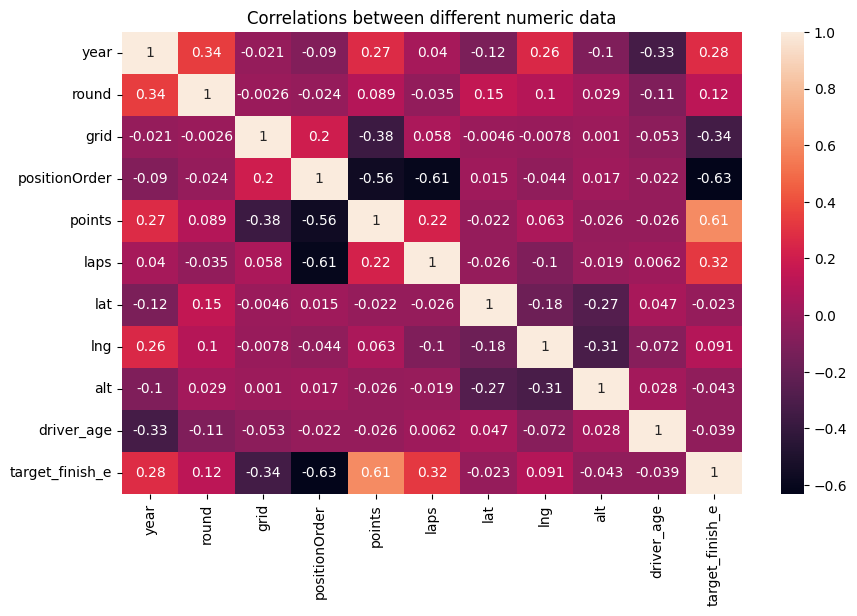

In [293]:
plt.figure(figsize=(10, 6))
plt.title("Correlations between different numeric data")
sns.heatmap(df[numeric].corr(), annot=True)


In [294]:
corr_matrix = df[numeric].corr()

In [295]:
target_corr = corr_matrix['target_finish_e'].drop('target_finish_e')  # exclude target itself
print(target_corr)

year             0.276936
round            0.123115
grid            -0.344964
positionOrder   -0.632000
points           0.610262
laps             0.322128
lat             -0.023301
lng              0.090647
alt             -0.043222
driver_age      -0.039325
Name: target_finish_e, dtype: float64


In [296]:
threshold = 0.6
high_corr_features_num = target_corr[abs(target_corr) > threshold]
high_corr_features_num = list(high_corr_features_num.index)
high_corr_features_num

['positionOrder', 'points']

In [297]:
def eta_squared(feature, target):
    groups = [target[feature == lvl] for lvl in feature.unique()]
    ss_between = sum([len(g)*(g.mean()-target.mean())**2 for g in groups])
    ss_total = ((target - target.mean())**2).sum()
    return ss_between / ss_total

In [298]:
cat = [feature for feature in df.columns if df[feature].dtype == 'O']
cat

['driver_nationality',
 'name',
 'constuctor_nationality',
 'constructor',
 'location',
 'country',
 'driver_name']

In [299]:
for i in range(len(cat)):
  print(f"EtA of {cat[i]} -> target: {eta_squared(df[cat[i]],df['target_finish_e']) }")


EtA of driver_nationality -> target: 0.06386925376517841
EtA of name -> target: 0.07004656239273722
EtA of constuctor_nationality -> target: 0.06817846339028946
EtA of constructor -> target: 0.23984141715271004
EtA of location -> target: 0.06987791836996278
EtA of country -> target: 0.04306934585738197
EtA of driver_name -> target: 0.28565480621300715


In [300]:
thres = 0.20
high_corr_features_cat = []
for i in range(len(cat)):
  if eta_squared(df[cat[i]],df['target_finish_e']) > thres:
    high_corr_features_cat.append(cat[i])
high_corr_features_cat

['constructor', 'driver_name']

In [301]:
df_final = df[high_corr_features_num + high_corr_features_cat]

In [302]:
df_final.head()

,positionOrder,points,constructor,driver_name
0,4,3.0,McLaren,Kimi Räikkönen
1,21,0.0,McLaren,John Watson
2,26,0.0,Maserati,Troy Ruttman
3,16,0.0,Haas F1 Team,Mick Schumacher
4,30,0.0,Euro Brun,Stefano Modena


In [303]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded = encoder.fit_transform(df_final[['constructor', 'driver_name']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['constructor', 'driver_name']))
df_final = df_final.drop(['constructor', 'driver_name'], axis=1)
df_final = pd.concat([df_final, encoded_df], axis=1)

In [304]:
df_final.head()

,positionOrder,points,constructor_AGS,constructor_ATS,constructor_Adams,constructor_Alfa Romeo,constructor_AlphaTauri,constructor_Alpine F1 Team,constructor_Alta,constructor_Amon,...,driver_name_Wolfgang von Trips,driver_name_Yannick Dalmas,driver_name_Yuji Ide,driver_name_Yuki Tsunoda,driver_name_Yves Cabantous,driver_name_Zsolt Baumgartner,driver_name_Élie Bayol,driver_name_Éric Bernard,driver_name_Érik Comas,driver_name_Óscar González
0,4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [305]:
from sklearn.model_selection import train_test_split

X = df_final
y = df['target_finish_e']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 851), (2000, 851), (8000,), (2000,))

# Using Random Forest

In [306]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Accuracy train:", accuracy_score(y_train, y_train_pred))
print("Accuracy test:", accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
acc_random_forest = accuracy_score(y_train, y_train_pred) * 100

Accuracy train: 0.878625
Accuracy test: 0.8695
Recall: 0.8473413379073756


In [307]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1417
           1       0.74      0.85      0.79       583

    accuracy                           0.87      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.88      0.87      0.87      2000



In [308]:
y_train.value_counts()
   #Used the class_wieght parameter to balance out the data

,count
target_finish_e,
0,5688
1,2312


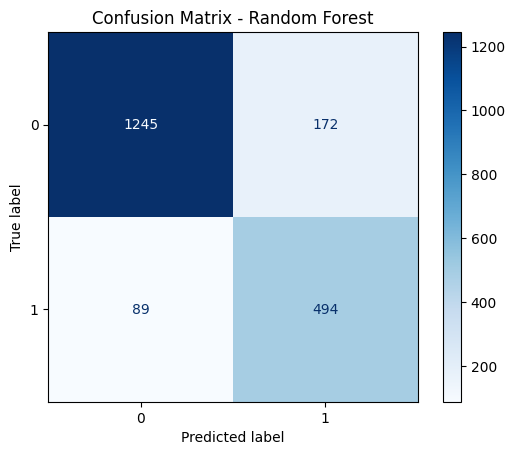

In [309]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [316]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train, y_train)

In [331]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_model.fit(X_train_upsampled, y_train_upsampled)

y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train_upsampled)

print("Accuracy train:", accuracy_score(y_train_upsampled, y_train_pred))
print("Accuracy test:", accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
acc_rf = accuracy_score(y_train_upsampled, y_train_pred) * 100

Accuracy train: 0.8744725738396625
Accuracy test: 0.8705
Recall: 0.8456260720411664


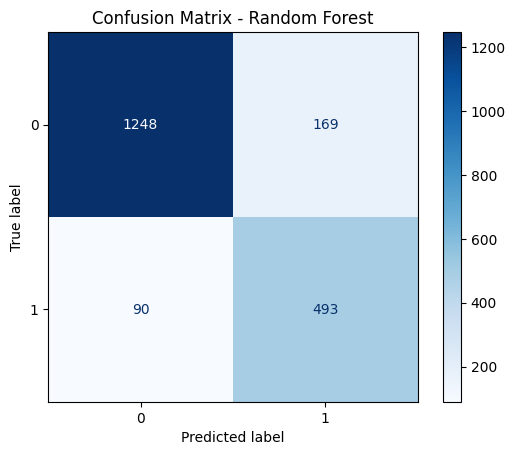

In [318]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Using XGBoost

In [319]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.897
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1417
           1       0.84      0.79      0.82       583

    accuracy                           0.90      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.90      0.90      0.90      2000



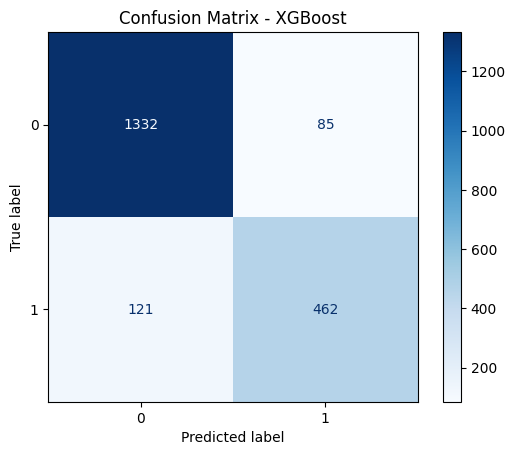

In [320]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [339]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_upsampled, y_train_upsampled)


y_pred = xgb_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
acc_xg = accuracy_score(y_test, y_pred) * 100

Accuracy: 0.8815
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1417
           1       0.77      0.86      0.81       583

    accuracy                           0.88      2000
   macro avg       0.85      0.87      0.86      2000
weighted avg       0.89      0.88      0.88      2000



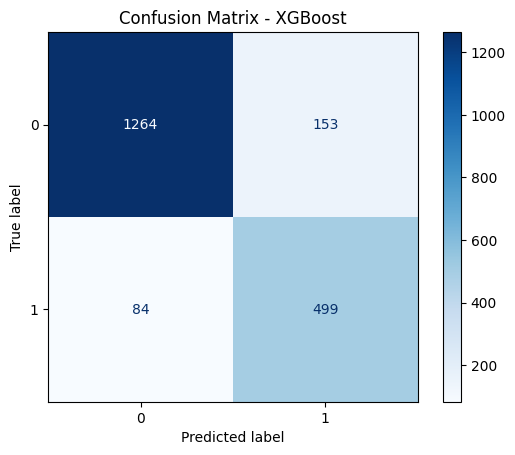

In [322]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

#Using SVM

In [323]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns


In [324]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', [col for col in X_train.columns if col not in numeric_features])
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [325]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [326]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_final, y_train_final)

y_pred = svr.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test, y_pred))

MSE: 0.1122637216836362


In [340]:
# Applying a threshold to convert continuous predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

acc_svm = accuracy_score(y_test, y_pred_binary) * 100
print("Accuracy:", acc_svm)

print(classification_report(y_test, y_pred_binary))

Accuracy: 88.14999999999999
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1417
           1       0.77      0.86      0.81       583

    accuracy                           0.88      2000
   macro avg       0.85      0.87      0.86      2000
weighted avg       0.89      0.88      0.88      2000



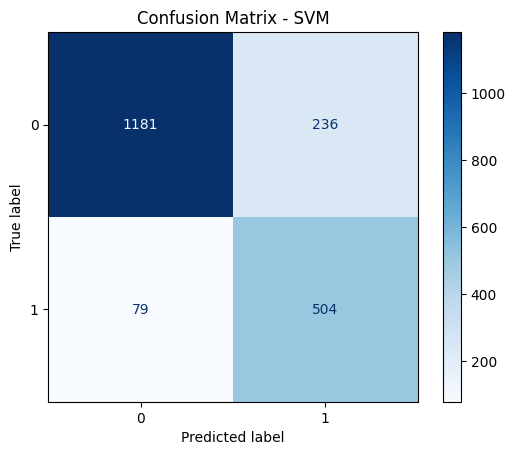

In [328]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - SVM")
plt.show()

# Summary

In [341]:
accuracies = {"Random Forest":acc_rf,
              "XGBoost": acc_xg,
              "SVM":acc_svm}

In [342]:
acc_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])
acc_df

,Model,Accuracy
0,Random Forest,87.447257
1,XGBoost,88.150000
2,SVM,88.150000


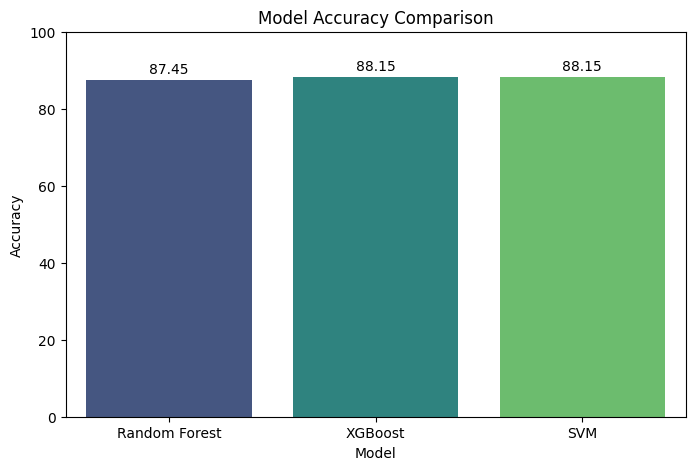

In [352]:
import seaborn as sns
plt.figure(figsize=(8,5))
ax = sns.barplot(x='Model', y='Accuracy', data=acc_df, hue='Model', legend=False, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)

for container in ax.containers: # Iterate through the bars
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, # X position (center of the bar)
                height + 1,                         # Y position (slightly above the bar)
                f'{height:.2f}',                    # The value to display (formatted to 2 decimal places)
                ha='center', va='bottom',           # Horizontal and vertical alignment
                fontsize=10, color='black')

plt.show()
